## BioExplain – Body Fat Biomarker Exploration

This notebook performs exploratory data analysis on a physiological dataset
used to predict body fat percentage. The objective is to identify interpretable,
stable biomarkers that exhibit meaningful relationships with body composition.


Install Libraries

In [266]:
!python3 -m pip install matplotlib seaborn pandas numpy scipy statsmodels scikit-learn shap

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


Import Libraries

In [267]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Machine Learning & Stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap

warnings.filterwarnings('ignore')

Load and Explore Data

In [268]:
df = pd.read_csv("../data/bodyfat.csv")
df.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


Summary of Data

In [269]:
# Summary
df.info()
print(100 * '-')
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Density  252 non-null    float64
 1   BodyFat  252 non-null    float64
 2   Age      252 non-null    int64  
 3   Weight   252 non-null    float64
 4   Height   252 non-null    float64
 5   Neck     252 non-null    float64
 6   Chest    252 non-null    float64
 7   Abdomen  252 non-null    float64
 8   Hip      252 non-null    float64
 9   Thigh    252 non-null    float64
 10  Knee     252 non-null    float64
 11  Ankle    252 non-null    float64
 12  Biceps   252 non-null    float64
 13  Forearm  252 non-null    float64
 14  Wrist    252 non-null    float64
dtypes: float64(14), int64(1)
memory usage: 29.7 KB
----------------------------------------------------------------------------------------------------


,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,1.055574,19.150794,44.884921,178.924405,70.148810,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762
std,0.019031,8.368740,12.602040,29.389160,3.662856,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585
min,0.995000,0.000000,22.000000,118.500000,29.500000,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000
25%,1.041400,12.475000,35.750000,159.000000,68.250000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,1.054900,19.200000,43.000000,176.500000,70.000000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000
75%,1.070400,25.300000,54.000000,197.000000,72.250000,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,1.108900,47.500000,81.000000,363.150000,77.750000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


All 15 columns are numerical (float64/int64) and there are zero missing values.
The features have vastly different ranges (e.g., Weight mean is ~179, Neck is ~38).

NULL and Duplicate checks

In [270]:
print(df.isnull().sum())
print(100 * "-")
print(df.duplicated().sum())

Density    0
BodyFat    0
Age        0
Weight     0
Height     0
Neck       0
Chest      0
Abdomen    0
Hip        0
Thigh      0
Knee       0
Ankle      0
Biceps     0
Forearm    0
Wrist      0
dtype: int64
----------------------------------------------------------------------------------------------------
0


Univariate Analysis - Distributions and Outliers

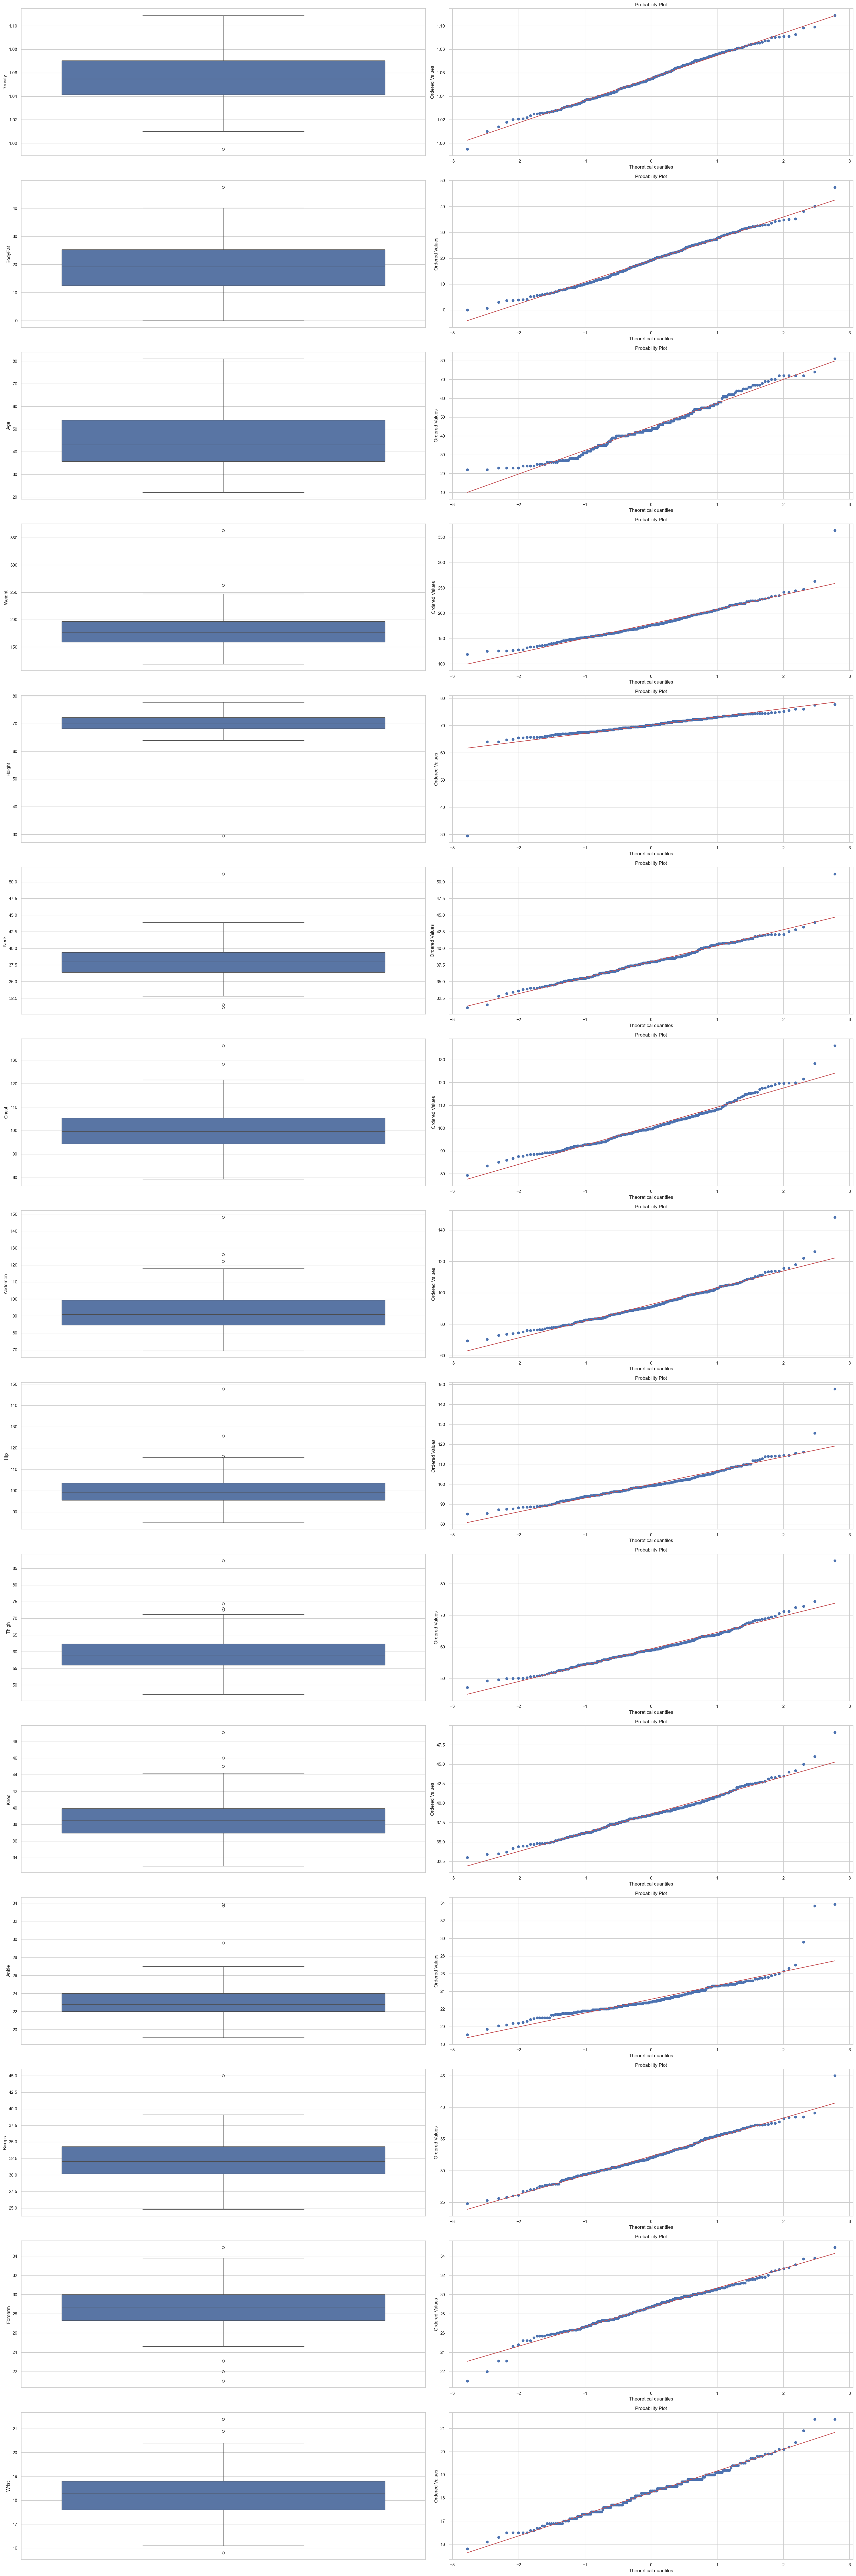

In [271]:
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(15,2, figsize = (30,90))

for idx, val in enumerate(df.columns):
    sns.boxplot(df[val], ax = ax[idx, 0])
    stats.probplot(df[val], plot = ax[idx, 1])

plt.tight_layout()
plt.show()

BoxPlots reveals several featuers having upper-end outliers.
Q-Q plots reveals several featuers are heavily "Right-Skewed".

Skewness & Distribution Analysis

In [272]:
df.skew().sort_values()

Height    -5.384987
Forearm   -0.219333
Density   -0.020176
BodyFat    0.146353
Wrist      0.281614
Age        0.283521
Biceps     0.285530
Knee       0.516744
Neck       0.552620
Chest      0.681556
Thigh      0.821210
Abdomen    0.838418
Weight     1.205263
Hip        1.497127
Ankle      2.255134
dtype: float64

Left-Skewed Data - Replacing minimum value of height with median

In [273]:
print(df['Height'].sort_values())

median_height = df['Height'].median()
df.loc[df['Height'] < 60, 'Height'] = median_height

41     29.50
215    64.00
73     64.00
28     64.75
35     65.00
       ...  
108    75.50
11     76.00
191    76.00
144    77.50
95     77.75
Name: Height, Length: 252, dtype: float64


Right-Skewed Data - Log Transformations for Weight, Hip & Ankle

In [274]:
df['Ankle_log'] = np.log1p(df['Ankle'])
df['Hip_log'] = np.log1p(df['Hip'])
df['Weight_log'] = np.log1p(df['Weight'])

print(df[['Ankle_log', 'Hip_log', 'Weight_log']].skew())

df = df.drop(columns=['Ankle', 'Hip', 'Weight'])

Ankle_log     1.519596
Hip_log       0.914442
Weight_log    0.323193
dtype: float64


Bivariate & Multivariate Analysis: Correlation Heatmap

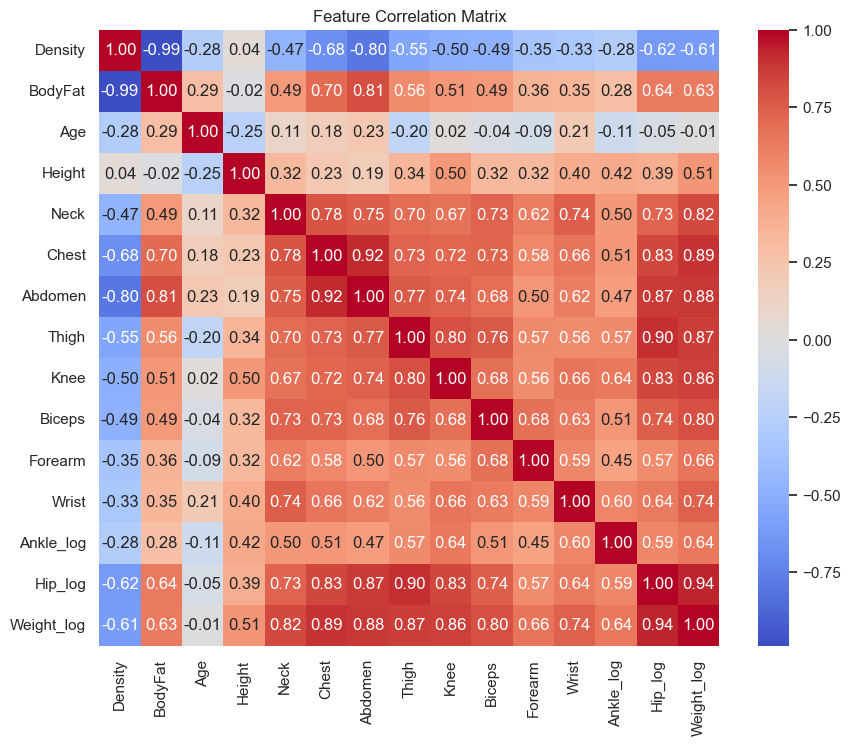

In [275]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

BodyFat is closely related with Density, Abdomen, Chest, Hip_log, Weight_log

Variance Inflation Factor Calculation : (Feature vs Feature)

In [276]:
def drop_high_vif(X, threshold=10.0):
    X_clean = X.copy()
    
    while True:
        X_with_const = add_constant(X_clean)
        
        vif_scores = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
        
        vif_series = pd.Series(vif_scores[1:], index=X_clean.columns)
        max_vif = vif_series.max()
        
        if max_vif > threshold:
            worst_feature = vif_series.idxmax()
            print(f"Dropping '{worst_feature}' (VIF: {max_vif:.1f})")
            X_clean = X_clean.drop(columns=[worst_feature])
        else:
            print(vif_series.sort_values(ascending=False))
            break
            
    return X_clean


X_starting_features = df.drop(columns=["BodyFat", "Density"])
X_eda_only = drop_high_vif(X_starting_features, threshold=10.0)

Dropping 'Weight_log' (VIF: 50.9)
Dropping 'Hip_log' (VIF: 11.7)
Abdomen      9.214383
Chest        7.877180
Thigh        6.229513
Knee         4.715009
Neck         3.920262
Biceps       3.503085
Wrist        3.314478
Forearm      2.165822
Age          2.081662
Ankle_log    2.024789
Height       1.707067
dtype: float64


DROPPED Features:


BodyFat was dropped because it can be mathematically derived directly from the Density column using Siri's Equation (BodyFat=495/Density−450). If Density is included in the training features, models will simply reverse-engineer this formula.

Weight_log and Hip_log, were dropped due to severe multicollinearity (VIF > 10).

Feature-Target Relationship: Scatterplot Analysis

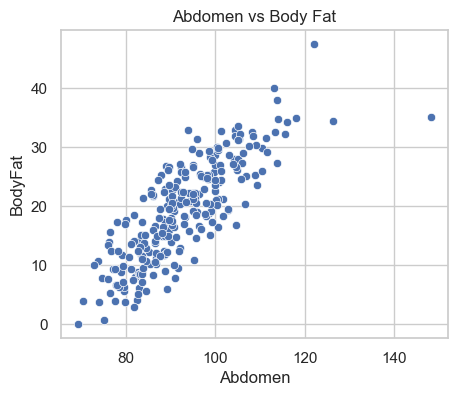

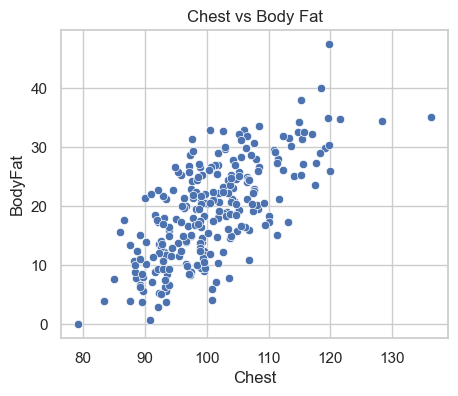

In [277]:
features = ["Abdomen", "Chest"]

for f in features:
    plt.figure(figsize=(5,4))
    sns.scatterplot(x=df[f], y=df["BodyFat"])
    plt.title(f"{f} vs Body Fat")
    plt.show()

Train Model with Lasso, Ridge, Linear Regression and Random Forest

In [279]:
X_all = df.drop(columns=["BodyFat", "Density"])
X_eda_only = df[["Abdomen", "Chest"]]
Y = df["BodyFat"]

models_to_test = {
    "Multiple Linear Regression (EDA Features)": (LinearRegression(), X_eda_only),
    "Lasso (All Features)": (LassoCV(cv=5, random_state=42), X_all),
    "Ridge (All Features)": (RidgeCV(cv=5), X_all),
    "Random Forest (All Features)": (RandomForestRegressor(n_estimators=100, random_state=42), X_all)
}

results_list = []

for model_name, (model, X_features) in models_to_test.items():
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model.fit(X_train_scaled, Y_train)
    Y_pred = model.predict(X_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    r2 = r2_score(Y_test, Y_pred)
    
    results_list.append({
        "Model": model_name,
        "RMSE": round(rmse, 3),
        "R2 Score": round(r2, 3)
    })

results_df = pd.DataFrame(results_list).sort_values(by="R2 Score", ascending=False).reset_index(drop=True)
print(results_df.to_string())

                                       Model   RMSE  R2 Score
0               Random Forest (All Features)  4.037     0.650
1                       Ridge (All Features)  4.456     0.573
2                       Lasso (All Features)  4.560     0.553
3  Multiple Linear Regression (EDA Features)  5.274     0.402


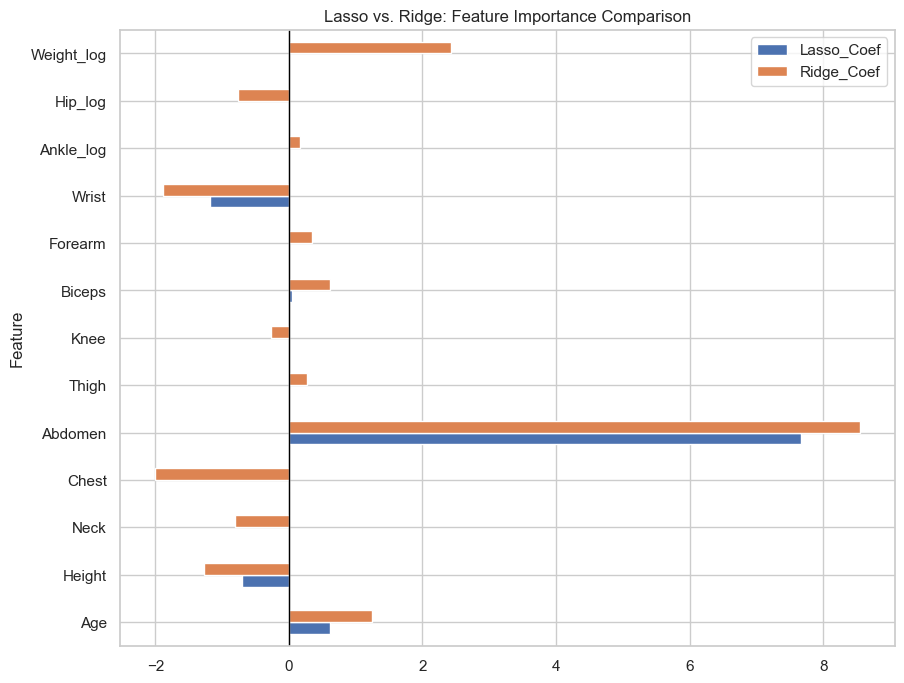

In [286]:
lasso_model = models_to_test["Lasso (All Features)"][0]
ridge_model = models_to_test["Ridge (All Features)"][0]

coef_comparison = pd.DataFrame({
    "Feature": X_all.columns,
    "Lasso_Coef": lasso_model.coef_,
    "Ridge_Coef": ridge_model.coef_
})

coef_comparison.set_index("Feature").plot(kind="barh", figsize=(10, 8))
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.title("Lasso vs. Ridge: Feature Importance Comparison")
plt.show()

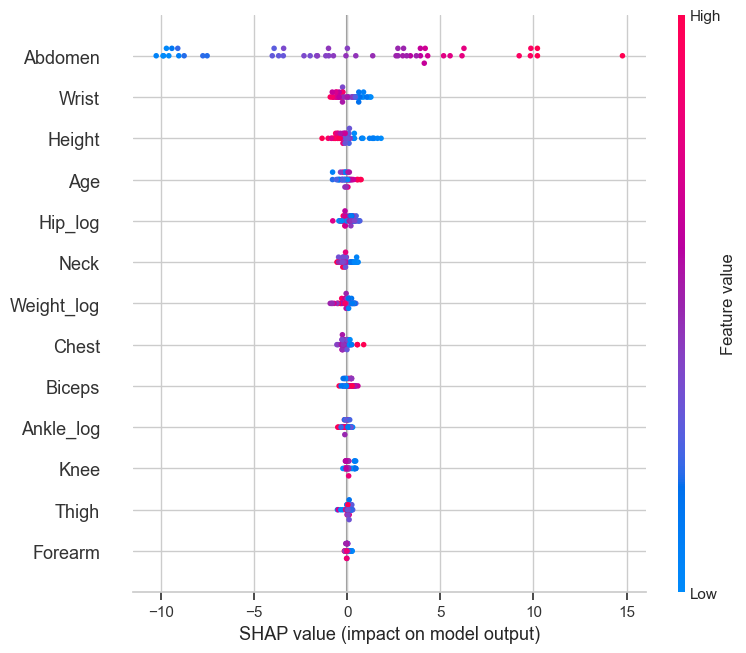

In [283]:
rf_model = models_to_test["Random Forest (All Features)"][0]

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_all.columns)